## **Importing Libraries**

In [1]:
!pip install pydub

In [2]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [3]:
import os
import h5py
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import soundfile as sf
import pandas as pd
from google.colab import files
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Downloading Data**

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/FMA_DATASET"

folders = ["fma_small", "fma_small_wav", "fma_metadata"]

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        file_count = sum([len(files) for _, _, files in os.walk(folder_path)])
        print(f"📂 {folder}: {file_count} dosya")
    else:
        print(f"⚠ {folder} klasörü bulunamadı!")

📂 fma_small: 8002 dosya
📂 fma_small_wav: 7997 dosya
📂 fma_metadata: 12 dosya


In [ ]:
!ls -lh "/content/drive/MyDrive/FMA_DATASET/fma_medium_wav/" | head -20

total 4.0K
drwx------ 158 root root 4.0K Feb 27 17:07 fma_medium


In [ ]:
!ls -lh "/content/drive/MyDrive/FMA_DATASET/fma_small/" | head -20

total 4.0K
drwx------ 158 root root 4.0K Mar  9 09:40 fma_small


In [ ]:
!du -sh "/content/drive/MyDrive/FMA_DATASET/fma_medium_wav"

123G	/content/drive/MyDrive/FMA_DATASET/fma_medium_wav


In [ ]:
!du -sh "/content/drive/MyDrive/FMA_DATASET/fma_small"

0	/content/drive/MyDrive/FMA_DATASET/fma_small


In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
small_audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")
tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

small_track_ids = []

for folder in os.listdir(small_audio_path):
    folder_path = os.path.join(small_audio_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav'):
                track_id = int(filename.split('.')[0])
                small_track_ids.append(track_id)

print(f"🎵 fma_small içinde bulunan şarkı ID sayısı: {len(small_track_ids)}")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df.loc[small_track_ids, [("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = genre_data["genre_top"].value_counts()

    print("\n🎯 fma_small klasöründeki Şarkı Tür Dağılımı:")
    print(genre_counts)
else:
    print("⚠ tracks.csv dosyası bulunamadı!")

🎵 fma_small içinde bulunan şarkı ID sayısı: 7997

🎯 fma_small klasöründeki Şarkı Tür Dağılımı:
genre_top
Hip-Hop          1000
Instrumental     1000
Folk             1000
Pop              1000
International    1000
Rock              999
Experimental      999
Electronic        999
Name: count, dtype: int64


In [4]:
classes = [
    "Pop", "Instrumental", "International", "Hip-Hop",
    "Folk", "Experimental", "Rock", "Electronic"
]

## **Convertin fma_medium to WAV**

In [ ]:
!apt-get update
!apt-get install -y ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,705 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_medium")
wav_output_path = os.path.join(dataset_path, "fma_medium_wav")

os.makedirs(wav_output_path, exist_ok=True)

successful_conversions = 0
failed_conversions = 0

for root, dirs, files in os.walk(audio_path):
    for file in files:
        if file.endswith('.mp3'):
            mp3_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, audio_path)
            wav_folder = os.path.join(wav_output_path, relative_path)
            os.makedirs(wav_folder, exist_ok=True)

            wav_path = os.path.join(wav_folder, file.replace('.mp3', '.wav'))

            if os.path.exists(wav_path):
                print(f"⏭️ Atlama: {wav_path} (Zaten mevcut)")
                continue
            try:
                print(f"🔊 {mp3_path} -> {wav_path}")
                audio = AudioSegment.from_mp3(mp3_path)
                audio.export(wav_path, format="wav")
                successful_conversions += 1
            except Exception as e:
                print(f"❌ Hata: {mp3_path} -> {wav_path} ({str(e)})")
                failed_conversions += 1

print(f"\n✅ Başarıyla dönüştürülen dosya sayısı: {successful_conversions}")
print(f"❌ Hata veren dosya sayısı: {failed_conversions}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124748.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124748.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124871.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124871.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124869.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124869.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124870.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124870.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124754.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124754.wav
🔊 /content/drive/MyDrive/FMA_DATASET/fma_medium/fma_medium/124/124875.mp3 -> /content/drive/MyDrive/FMA_DATASET/fma_medium_wav/fma_medium/124/124875.wav
🔊 /content/drive/MyDrive/FMA_DATASE

In [ ]:
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/FMA_DATASET"
wav_audio_path = os.path.join(dataset_path, "fma_medium_wav")
metadata_path = os.path.join(dataset_path, "fma_metadata")

total_wav_files = sum([len(files) for _, _, files in os.walk(wav_audio_path)])
print(f"🎵 Toplam WAV Şarkı Sayısı: {total_wav_files}")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df[[("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = {}
    for root, _, files in os.walk(wav_audio_path):
        for file in files:
            if file.endswith(".wav"):
                track_id = int(file.replace(".wav", ""))

                if track_id in genre_data.index:
                    genre = genre_data.loc[track_id, "genre_top"]
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1

    print("\n🎵 Türlere Göre WAV Şarkı Dağılımı:")
    for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {genre}: {count} şarkı")

else:
    print("⚠ tracks.csv dosyası bulunamadı!")

print(f"Türe atanamayan şarkı sayısı: {total_wav_files - sum(genre_counts.values())}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎵 Toplam WAV Şarkı Sayısı: 24985

🎵 Türlere Göre WAV Şarkı Dağılımı:
  - Rock: 7098 şarkı
  - Electronic: 6311 şarkı
  - Experimental: 2250 şarkı
  - Hip-Hop: 2197 şarkı
  - Folk: 1518 şarkı
  - Instrumental: 1349 şarkı
  - Pop: 1186 şarkı
  - International: 1018 şarkı
  - Classical: 619 şarkı
  - Old-Time / Historic: 510 şarkı
  - Jazz: 384 şarkı
  - Country: 178 şarkı
  - Soul-RnB: 154 şarkı
  - Spoken: 118 şarkı
  - Blues: 74 şarkı
  - Easy Listening: 21 şarkı
Türe atanamayan şarkı sayısı: 0


## **Visualizing Single Audio**

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_small_wav/fma_small/000'
audioName = dataSetPath + '/000002.wav'

print(os.listdir(dataSetPath))

['000709.wav', '000714.wav', '000540.wav', '000193.wav', '000620.wav', '000890.wav', '000141.wav', '000821.wav', '000716.wav', '000204.wav', '000777.wav', '000825.wav', '000892.wav', '000210.wav', '000705.wav', '000148.wav', '000704.wav', '000002.wav', '000667.wav', '000995.wav', '000368.wav', '000897.wav', '000197.wav', '000010.wav', '000666.wav', '000574.wav', '000814.wav', '000534.wav', '000708.wav', '000695.wav', '000676.wav', '000213.wav', '000200.wav', '000140.wav', '000707.wav', '000690.wav', '000621.wav', '000715.wav', '000459.wav', '000546.wav', '000718.wav', '000998.wav', '000615.wav', '000997.wav', '000424.wav', '000602.wav', '000822.wav', '000182.wav', '000625.wav', '000211.wav', '000256.wav', '000853.wav', '000194.wav', '000212.wav', '000005.wav', '000255.wav', '000203.wav', '000993.wav', '000207.wav', '000694.wav', '000190.wav', '000706.wav']


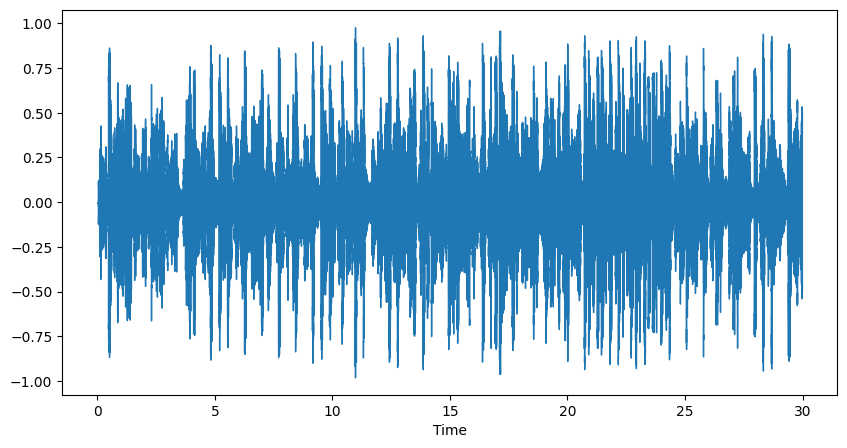

In [ ]:
y,sr = librosa.load(audioName, sr = 44100)
plt.figure(figsize = (10,5))
librosa.display.waveshow(y, sr = sr)

In [ ]:
from IPython.display import Audio
Audio(data = y, rate = sr)

Output hidden; open in https://colab.research.google.com to view.

## **Visualization Chunks of the Single Audio**

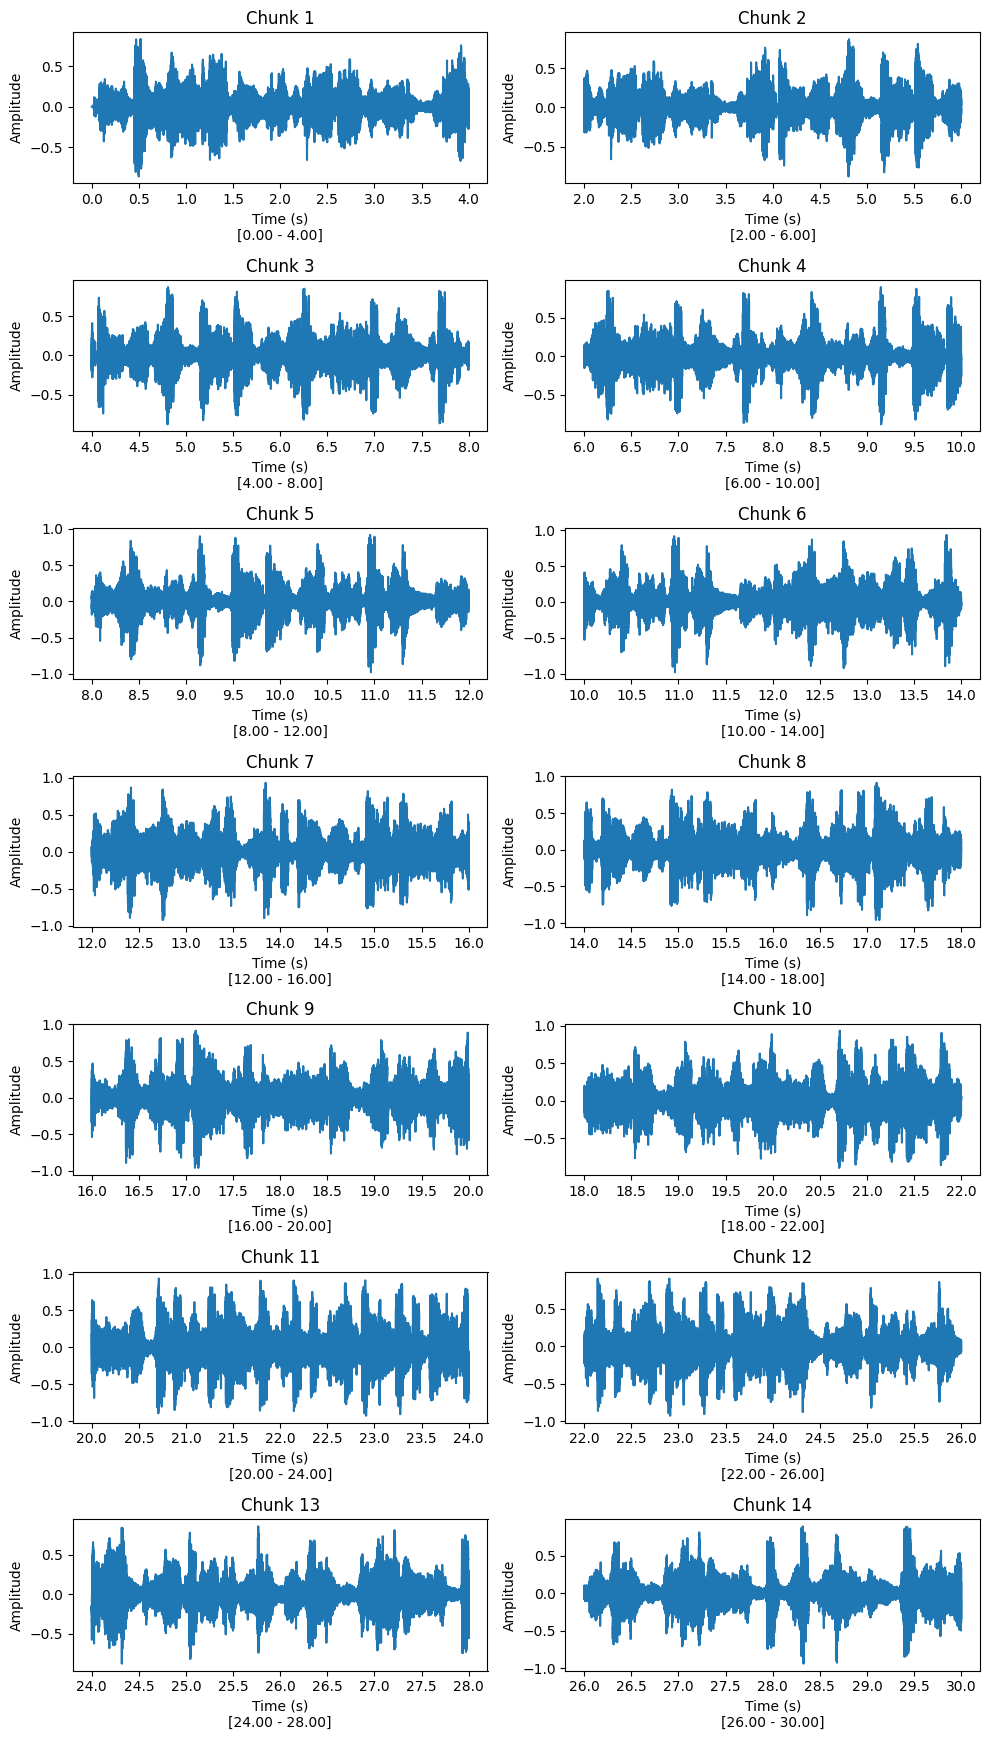

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_small/fma_small'
audioName = dataSetPath + '/000/000002.mp3'
y, sr = librosa.load(audioName, sr=None)

chunkDuration = 4
overlapDuration = 2

chunkSamples = chunkDuration * sr
overlapSamples = overlapDuration * sr

numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

numRows = int(np.ceil(numChunks / 2))

fig, axes = plt.subplots(numRows, 2, figsize=(10, numRows * 2.5))
axes = axes.flatten()

for i in range(numChunks):
    start = i * (chunkSamples - overlapSamples)
    end = start + chunkSamples
    chunk = y[start:end]

    start_time_sec = start / sr
    end_time_sec = end / sr

    time_axis = np.linspace(start_time_sec, end_time_sec, len(chunk))

    ax = axes[i]
    ax.plot(time_axis, chunk)
    ax.set_xlabel(f'Time (s)\n[{start_time_sec:.2f} - {end_time_sec:.2f}]')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Chunk {i+1}')

for j in range(numChunks, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **Single Audio Melspectrogram**

In [ ]:
def plotMelspectrogram(y, sr):
  spectogram = librosa.feature.melspectrogram(y = y, sr = sr)
  spectogramDb = librosa.power_to_db(spectogram, ref = np.max)
  plt.figure(figsize = (10, 4))
  librosa.display.specshow(spectogramDb, sr = sr, x_axis = 'time', y_axis = 'mel')
  plt.colorbar(format = '%2.0f dB')
  plt.title("Spectogram")
  plt.tight_layout()
  plt.show()

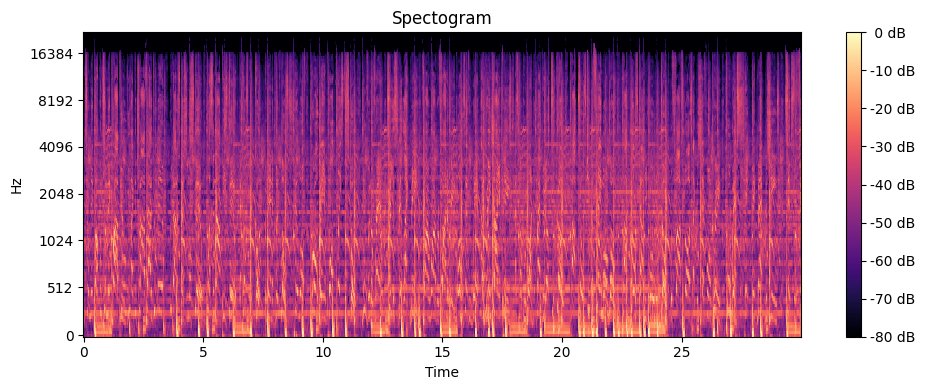

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_small_wav/fma_small/000'
audioName = dataSetPath + '/000002.wav'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogram(y, sr)

## **Chunk's Melspectrogram Visualization**

In [ ]:
def plotMelspectrogramChunks(y, sr):
    chunkDuration = 4
    overlapDuration = 2

    chunkSamples = chunkDuration * sr
    overlapSamples = overlapDuration * sr

    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1
    numRows = int(np.ceil(numChunks / 2))

    fig, axes = plt.subplots(numRows, 2, figsize=(12, numRows * 3))
    axes = axes.flatten()

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        start_time_sec = start / sr
        end_time_sec = end / sr

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        ax = axes[i]
        img = librosa.display.specshow(spectrogram_db, sr=sr, ax=ax, y_axis='mel', x_axis=None)
        ax.set_title(f'Chunk {i+1} ({start_time_sec:.2f} - {end_time_sec:.2f} s)')

        num_ticks = 5
        time_ticks = np.linspace(0, spectrogram_db.shape[1], num_ticks)
        time_labels = np.linspace(start_time_sec, end_time_sec, num_ticks)
        ax.set_xticks(time_ticks)
        ax.set_xticklabels([f'{t:.2f}' for t in time_labels])
        ax.set_xlabel('Time (seconds)')

        cbar = ax.figure.colorbar(img, ax=ax, format="%+2.0f dB")
        cbar.ax.tick_params(labelsize=8)

    for j in range(numChunks, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
dataSetPath = '/content/drive/MyDrive/FMA_DATASET/fma_small_wav/fma_small/000'
audioName = dataSetPath + '/000002.wav'
y,sr = librosa.load(audioName, sr = 44100)
plotMelspectrogramChunks(y = y, sr = sr)

Output hidden; open in https://colab.research.google.com to view.

## **All FMA Medium Data Set Melspectrogram**

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")

classes = [
    "Pop", "Instrumental", "International", "Hip-Hop",
    "Folk", "Experimental", "Rock", "Electronic"
]

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")
tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])
genre_data = tracks_df[[("track", "genre_top")]].dropna()
genre_data.columns = ["genre_top"]

genre_data = genre_data[genre_data["genre_top"].isin(classes)]
id_to_genre = genre_data.to_dict()["genre_top"]

chunk_duration = 4
overlap_duration = 2

In [ ]:
def MelspectrogramChunks(y, sr, targetShape, data, labels, genre):
    chunkSamples = chunk_duration * sr
    overlapSamples = overlap_duration * sr
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        if len(chunk) < chunkSamples:
            pad_width = chunkSamples - len(chunk)
            chunk = np.pad(chunk, (0, pad_width), mode='constant')

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        resizedSpectrogram = resize(np.expand_dims(spectrogram, axis=-1), targetShape)

        data.append(resizedSpectrogram)
        labels.append(classes.index(genre))

In [ ]:
def loadAndPreprocessData(audio_path, targetShape=(128, 128)):
    data, labels = [], []
    for folder in sorted(os.listdir(audio_path)):
        folder_path = os.path.join(audio_path, folder)
        if os.path.isdir(folder_path):
            print(f"İşleniyor: {folder}")
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_id = int(file.split('.')[0])
                    file_path = os.path.join(folder_path, file)
                    if file_id in id_to_genre:
                        genre = id_to_genre[file_id]
                        if genre in classes:
                            try:
                                audioData, sampleRate = librosa.load(file_path, sr=None)
                                MelspectrogramChunks(audioData, sampleRate, targetShape, data, labels, genre)
                            except Exception as e:
                                print(f"⚠ {file_path} atlandı. Hata: {e}")
    return np.array(data), np.array(labels)

data, labels = loadAndPreprocessData(audio_path)

labels = to_categorical(labels, num_classes=len(classes))

İşleniyor: 000
İşleniyor: 001
İşleniyor: 002
İşleniyor: 003
İşleniyor: 004
İşleniyor: 005
İşleniyor: 006
İşleniyor: 007
İşleniyor: 008
İşleniyor: 009
İşleniyor: 010
İşleniyor: 011
İşleniyor: 012
İşleniyor: 013
İşleniyor: 014
İşleniyor: 015
İşleniyor: 016
İşleniyor: 017
İşleniyor: 018
İşleniyor: 019
İşleniyor: 020
İşleniyor: 021
İşleniyor: 022
İşleniyor: 023
İşleniyor: 024
İşleniyor: 025
İşleniyor: 026
İşleniyor: 027
İşleniyor: 028
İşleniyor: 029
İşleniyor: 030
İşleniyor: 031
İşleniyor: 032
İşleniyor: 033
İşleniyor: 034
İşleniyor: 035
İşleniyor: 036
İşleniyor: 037
İşleniyor: 038
İşleniyor: 039
İşleniyor: 040
İşleniyor: 041
İşleniyor: 042
İşleniyor: 043
İşleniyor: 044
İşleniyor: 045
İşleniyor: 046
İşleniyor: 047
İşleniyor: 048
İşleniyor: 049
İşleniyor: 050
İşleniyor: 051
İşleniyor: 052
İşleniyor: 053
İşleniyor: 054
İşleniyor: 055
İşleniyor: 056
İşleniyor: 057
İşleniyor: 058
İşleniyor: 059
İşleniyor: 060
İşleniyor: 061
İşleniyor: 062
İşleniyor: 063
İşleniyor: 064
İşleniyor: 065
İşleniyor:

In [ ]:
print(f"🎵 Toplam Örnek Sayısı: {len(data)}")
print(f"📊 Veri Şekli: {data.shape}, Etiket Şekli: {labels.shape}")

🎵 Toplam Örnek Sayısı: 115266
📊 Veri Şekli: (115266, 128, 128, 1), Etiket Şekli: (115266, 8)


In [ ]:
import collections
from collections import Counter

label_counts = Counter(labels.argmax(axis=1))

print("🎵 Tür Dağılımı:")
for genre_index, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {classes[genre_index]}: {count} örnek")

🎵 Tür Dağılımı:
  - Pop: 14443 örnek
  - Folk: 14435 örnek
  - International: 14428 örnek
  - Electronic: 14410 örnek
  - Rock: 14407 örnek
  - Experimental: 14398 örnek
  - Instrumental: 14390 örnek
  - Hip-Hop: 14355 örnek


In [ ]:
save_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/"

np.save(os.path.join(save_path, "data.npy"), data)
np.save(os.path.join(save_path, "labels.npy"), labels)

print(f"✅ Veriler başarıyla kaydedildi: {save_path}")

✅ Veriler başarıyla kaydedildi: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/


In [5]:
load_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/"

data_file = os.path.join(load_path, "data.npy")
labels_file = os.path.join(load_path, "labels.npy")

if os.path.exists(data_file) and os.path.exists(labels_file):
    print("✅ Veriler Drive'da bulundu! Şimdi yükleniyor...")

    data = np.load(data_file)
    labels = np.load(labels_file)

    print(f"🎵 Data Şekli: {data.shape}")
    print(f"🎼 Labels Şekli: {labels.shape}")
else:
    print("⚠ Veriler Drive'da bulunamadı! Kaydın tamamlanıp tamamlanmadığını tekrar kontrol et.")

✅ Veriler Drive'da bulundu! Şimdi yükleniyor...
🎵 Data Şekli: (115266, 128, 128, 1)
🎼 Labels Şekli: (115266, 8)


## **Splitting Dataset into Training and Test Set**

In [6]:
XTrain, XTest, YTrain, YTest = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [7]:
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy', XTrain)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy', YTrain)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy', XTest)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy', YTest)

In [ ]:
x_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy'
y_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy'
x_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy'
y_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

hdf5_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/data.h5'

with h5py.File(hdf5_path, 'w') as f:
    f.create_dataset('XTrain', data=XTrain, compression="gzip")
    f.create_dataset('YTrain', data=YTrain, compression="gzip")
    f.create_dataset('XTest', data=XTest, compression="gzip")
    f.create_dataset('YTest', data=YTest, compression="gzip")

print("Veri HDF5 formatına kaydedildi.")

Veri HDF5 formatına kaydedildi.


In [ ]:
hdf5_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_MEDIUM/CNN/data.h5'
f = h5py.File(hdf5_path, 'r')

XTrain = f['XTrain']
YTrain = f['YTrain']
XTest = f['XTest']
YTest = f['YTest']

In [8]:
file_paths = [
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy"
]

for file_path in file_paths:
    if os.path.exists(file_path):
        print(f"Dosya bulundu: {file_path}")
    else:
        print(f"Dosya bulunamadı: {file_path}")

Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy


In [ ]:
x_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy'
y_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy'
x_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy'
y_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

NameError: name 'np' is not defined

In [ ]:
del XTrain
del XTest
del YTrain
del YTest

In [9]:
XTrain[0].shape

(128, 128, 1)

## **Building Model**

In [10]:
model = tf.keras.models.Sequential()

input_shape = (128, 128, 1)

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units = 1200, activation = 'relu'))

model.add(Dropout(0.45))

model.add(Dense(units = len(classes), activation = 'softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           9,608 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,180,056 (27.39 MB)

 Trainable params: 7,180,056 (27.39 MB)

 Non-trainable params: 0 (0.00 B)

## **Compile the Model**

In [11]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Training the Model**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = test_datagen.flow(XTest, YTest, batch_size=32)

trainingHistory = model.fit(train_generator, epochs=15, validation_data=test_generator)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ━━━━━━━━━━━━━━━━━━━━ 101s 30ms/step - accuracy: 0.2782 - loss: 1.8443 - val_accuracy: 0.5186 - val_loss: 1.3603
Epoch 2/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.5350 - loss: 1.3226 - val_accuracy: 0.5959 - val_loss: 1.1650
Epoch 3/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.6090 - loss: 1.1256 - val_accuracy: 0.6480 - val_loss: 1.0166
Epoch 4/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.6668 - loss: 0.9667 - val_accuracy: 0.7027 - val_loss: 0.8702
Epoch 5/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.7317 - loss: 0.7791 - val_accuracy: 0.7447 - val_loss: 0.7458
Epoch 6/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.7953 - loss: 0.5995 - val_accuracy: 0.7798 - val_loss: 0.6557
Epoch 7/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.8432 - loss: 0.4541 - val_accuracy: 0.8098 - val_loss: 0.5653
Epoch 8/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.8852 - loss: 0.3

NameError: name 'f' is not defined

In [ ]:
del train_generator
del test_generator
del train_datagen
del test_datagen

## **Saving Model & Training Data**

In [14]:
model.save('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/Trained_Model_FMA_SMALL.keras')

In [15]:
import json
with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/Training_History.json', 'w') as f:
    json.dump(trainingHistory.history, f)

In [19]:
from tensorflow.keras.models import load_model
Loaded_Model = load_model('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/Trained_Model_FMA_SMALL.keras')

In [17]:
import json

with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/Training_History.json', 'r') as f:
    Training_History_Data = json.load(f)

In [18]:
Training_History_Data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## **Model Evaluation**

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

eval_datagen = ImageDataGenerator()

train_eval_generator = eval_datagen.flow(XTrain, YTrain, batch_size=32)
test_eval_generator = eval_datagen.flow(XTest, YTest, batch_size=32)

trainLoss, trainAccuracy = Loaded_Model.evaluate(train_eval_generator)
valLoss, valAccuracy = Loaded_Model.evaluate(test_eval_generator)

print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")
print(f"Validation Loss: {valLoss}, Validation Accuracy: {valAccuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9883 - loss: 0.0375
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8856 - loss: 0.4382
Train Loss: 0.03808441013097763, Train Accuracy: 0.9874528050422668
Validation Loss: 0.4203704595565796, Validation Accuracy: 0.8893033862113953


In [23]:
results = {
    "Train Loss": trainLoss,
    "Train Accuracy": trainAccuracy,
    "Validation Loss": valLoss,
    "Validation Accuracy": valAccuracy
}

results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/evaluation_results.json"

with open(results_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Evaluation results saved to {results_path}")

Evaluation results saved to /content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/evaluation_results.json


In [25]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/evaluation_results.json"

with open(results_path, "r") as json_file:
    evaluation_results = json.load(json_file)

trainLoss = evaluation_results["Train Loss"]
trainAccuracy = evaluation_results["Train Accuracy"]
valLoss = evaluation_results["Validation Loss"]
valAccuracy = evaluation_results["Validation Accuracy"]

In [ ]:
del trainLoss
del trainAccuracy
del valLoss
del valAccuracy

## **Accuracy & Loss Visualization**

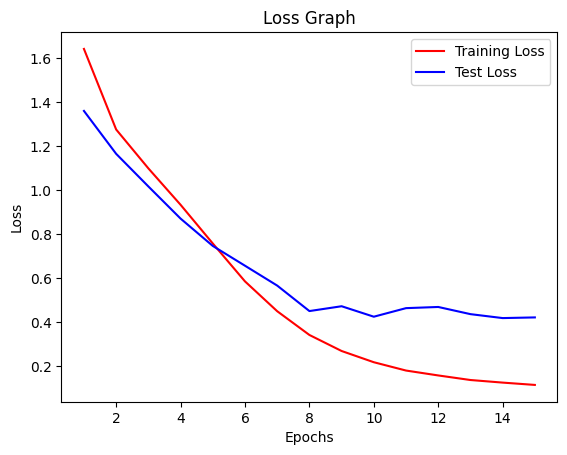

In [26]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, Training_History_Data['loss'], label = "Training Loss", color = 'red')
plt.plot(epochs, Training_History_Data['val_loss'], label = "Test Loss", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

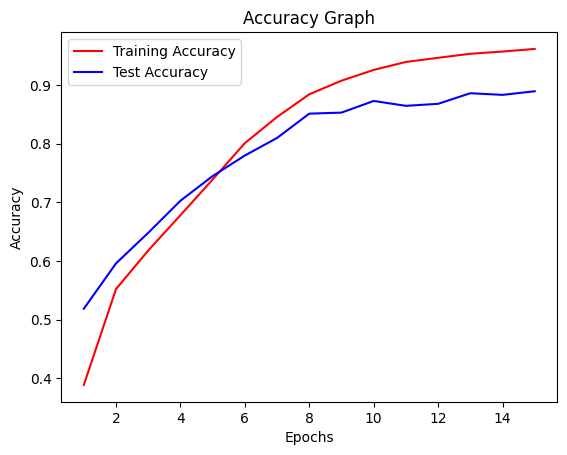

In [27]:
epochs = [i for i in range(1, 16)]
plt.plot(epochs, Training_History_Data['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, Training_History_Data['val_accuracy'], label = "Test Accuracy", color = 'blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

## **Metrics**

In [28]:
print("XTest Shape:", XTest.shape)
print("YTest Shape:", YTest.shape)

XTest Shape: (23054, 128, 128, 1)
YTest Shape: (23054, 8)


In [29]:
YPred = Loaded_Model.predict(XTest)
print("YPred Shape:", YPred.shape)

721/721 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
YPred Shape: (23054, 8)


In [30]:
predictedCategories = np.argmax(YPred, axis=1)
trueCategories = np.argmax(YTest, axis=1)

In [31]:
print("Predicted Categories:", predictedCategories)
print("True Categories:", trueCategories)

Predicted Categories: [5 2 4 ... 4 1 0]
True Categories: [5 6 4 ... 4 1 0]


In [32]:
cm = confusion_matrix(trueCategories, predictedCategories)
print(classification_report(trueCategories, predictedCategories, target_names=classes))

               precision    recall  f1-score   support

          Pop       0.88      0.79      0.84      2955
 Instrumental       0.86      0.92      0.89      2898
International       0.86      0.93      0.89      2802
      Hip-Hop       0.95      0.89      0.92      2910
         Folk       0.84      0.92      0.88      2959
 Experimental       0.90      0.86      0.88      2861
         Rock       0.93      0.89      0.91      2797
   Electronic       0.90      0.91      0.90      2872

     accuracy                           0.89     23054
    macro avg       0.89      0.89      0.89     23054
 weighted avg       0.89      0.89      0.89     23054



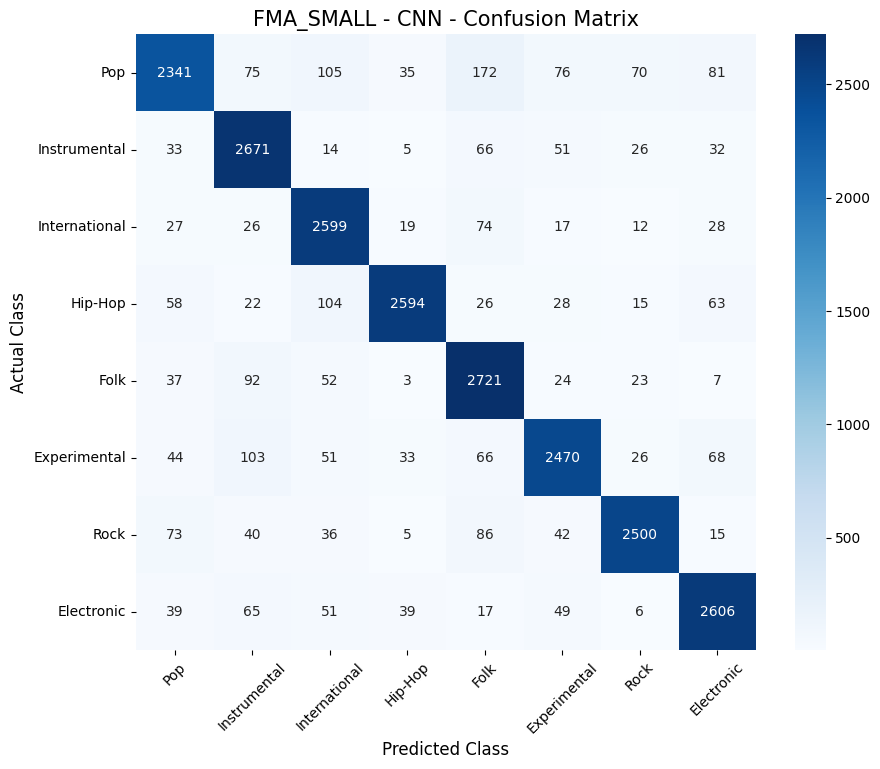

In [37]:
cm = confusion_matrix(trueCategories, predictedCategories)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("FMA_SMALL - CNN - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

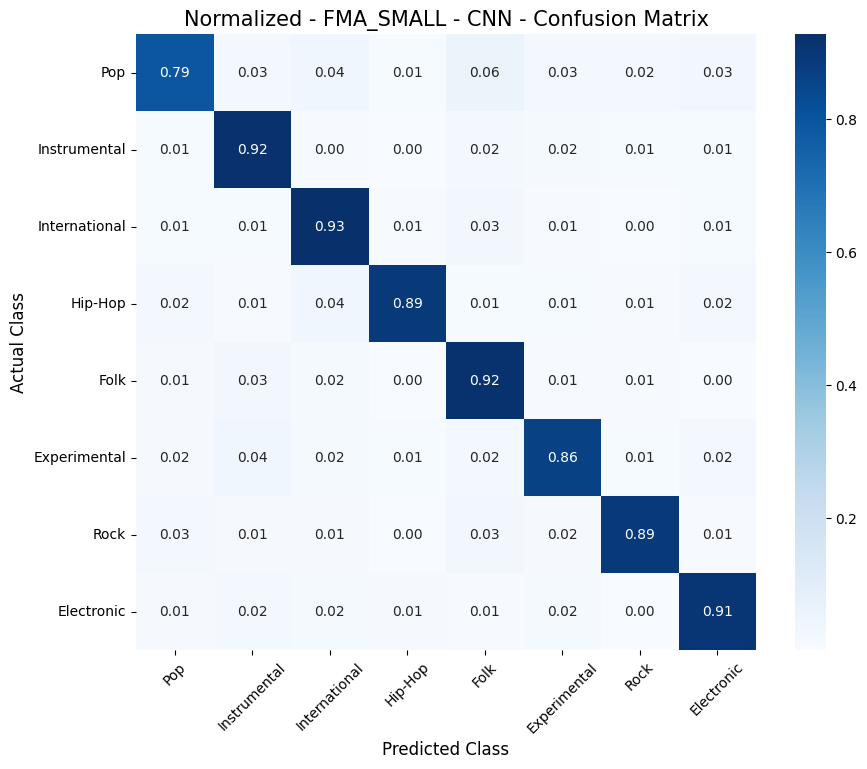

In [38]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized - FMA_SMALL - CNN - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()